# 模型拟合

In [1]:
# import lib
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('fivethirtyeight')

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer
import time
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

In [4]:
import os
import gc

In [5]:
# import data
X = pd.read_csv('../data/features/trainX.csv')
y = pd.read_csv('../data/features/trainY.csv', header=None)
testX = pd.read_csv('../data/features/testX.csv')

In [6]:
ids = testX.id
testX = testX.drop(['id'], axis=1)

In [7]:
# ROC
import matplotlib.pyplot as plt
def plotROC(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[2], tpr[2], _ = roc_curve(y_test, y_score)
    roc_auc[2] = auc(fpr[2], tpr[2])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # plot it
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

注意这里一定要进行分层抽样，否则会仅有的极少数的正样本大部分出现在训练集或者测试集。

In [9]:
np.sum(y_train == 0) / np.sum(y_train == 1)

0    136.687093
dtype: float64

## XGBoost[0.774493]

### 简单尝试

In [10]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              random_state=42, 
                              eval_metric="auc",
                              learning_rate=0.05,
                              max_depth=3,
                              n_estimators=150,
                              n_jobs=-1,
                              tree_method = 'hist',
                              scale_pos_weight=136)  # sum(y == 0) / sum(y == 1)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=136, seed=None,
              silent=None, subsample=1, tree_method='hist', verbosity=1)

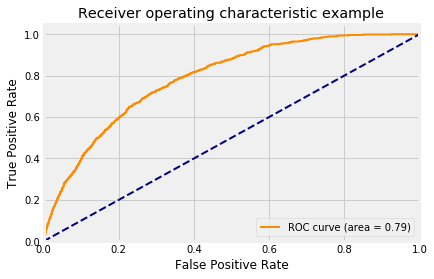

In [11]:
# training auc
# roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:,1])
plotROC(y_train, xgb_model.predict_proba(X_train)[:,1])

In [12]:
# test auc
y_pred = xgb_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.6991692698397557

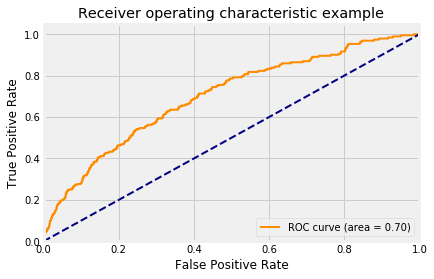

In [13]:
plotROC(y_test, y_pred)

In [14]:
# confusion matrix
y_pred_class = xgb_model.predict(X_test)
confusion_matrix(y_test, y_pred_class)

array([[18648,  7562],
       [   84,   108]])

### 调参

In [15]:
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count = 1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    score_mean = 0
    for tr_idx, val_idx in skf.split(X_train, y_train.values.ravel()):
        clf = xgb.XGBClassifier(
            objective="binary:logistic",
            n_estimators=300, random_state=4, verbose=True, 
            tree_method='hist', 
            scale_pos_weight=136,
            n_jobs=-1,
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr.values.ravel())
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


In [16]:
space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 2, 6, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(10, 100, 10))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(10, 200, 20))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [0.7, 0.8, 0.9, 1]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.7, 1),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.7, 1)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}

In [17]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Print best parameters
best_params = space_eval(space, best)

                                                    
############## New Run ################
params = {'max_depth': 5, 'gamma': '0.650', 'subsample': '0.80', 'reg_alpha': '0.042', 'reg_lambda': '0.278', 'learning_rate': '0.046', 'num_leaves': '60.000', 'colsample_bytree': '0.881', 'min_child_samples': '70.000', 'feature_fraction': '0.820', 'bagging_fraction': '0.907'}
1 CV - score: 0.6735                                
2 CV - score: 0.6872                                
3 CV - score: 0.6526                                
4 CV - score: 0.6548                                
5 CV - score: 0.6647                                
Total Time Run: 1.31                                
Mean ROC_AUC: 0.6665786596663059                    
                                                                              
############## New Run ################
params = {'max_depth': 4, 'gamma': '0.328', 'subsample': '0.90', 'reg_alpha': '0.214', 'reg_lambda': '0.047', 'learning_rate': '0.044', 'nu

1 CV - score: 0.6206                                                          
2 CV - score: 0.6234                                                          
3 CV - score: 0.5948                                                          
4 CV - score: 0.5721                                                          
5 CV - score: 0.6213                                                          
Total Time Run: 1.32                                                          
Mean ROC_AUC: 0.606425962702059                                               
                                                                              
############## New Run ################
params = {'max_depth': 4, 'gamma': '0.280', 'subsample': '0.70', 'reg_alpha': '0.103', 'reg_lambda': '0.221', 'learning_rate': '0.190', 'num_leaves': '60.000', 'colsample_bytree': '0.894', 'min_child_samples': '50.000', 'feature_fraction': '0.848', 'bagging_fraction': '0.710'}
1 CV - score: 0.6244                              

In [18]:
best_params['max_depth'] = int(best_params['max_depth'])
print("BEST PARAMS: ", best_params)

BEST PARAMS:  {'bagging_fraction': 0.9734434050691314, 'colsample_bytree': 0.9111958704779868, 'feature_fraction': 0.7923171042287418, 'gamma': 0.6556407536163212, 'learning_rate': 0.019735040386522542, 'max_depth': 3, 'min_child_samples': 130, 'num_leaves': 40, 'reg_alpha': 0.24259740906632582, 'reg_lambda': 0.07061464676596146, 'subsample': 0.8}


In [19]:
clf = xgb.XGBClassifier(
    n_estimators=300,
    **best_params,
    tree_method='hist',
    eval_metric="auc",
    n_jobs=-1,
    scale_pos_weight=136
)
clf.fit(X_train, y_train.values.ravel())

XGBClassifier(bagging_fraction=0.9734434050691314, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9111958704779868, eval_metric='auc',
              feature_fraction=0.7923171042287418, gamma=0.6556407536163212,
              learning_rate=0.019735040386522542, max_delta_step=0, max_depth=3,
              min_child_samples=130, min_child_weight=1, missing=None,
              n_estimators=300, n_jobs=-1, nthread=None, num_leaves=40,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.24259740906632582, reg_lambda=0.07061464676596146,
              scale_pos_weight=136, seed=None, silent=None, subsample=0.8,
              tree_method='hist', verbosity=1)

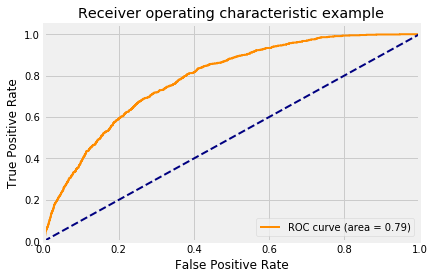

In [20]:
y_train_pred = clf.predict_proba(X_train)[:,1]
plotROC(y_train, y_train_pred)

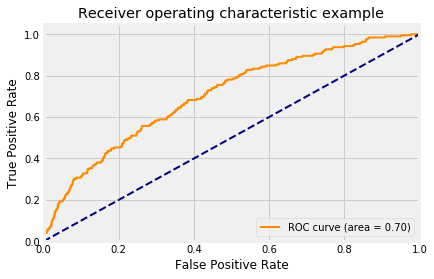

In [21]:
y_pred = clf.predict_proba(X_test)[:,1]
plotROC(y_test, y_pred)

In [22]:
# train with all data
clf.fit(X, y.values.ravel(), verbose=1)

XGBClassifier(bagging_fraction=0.9734434050691314, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9111958704779868, eval_metric='auc',
              feature_fraction=0.7923171042287418, gamma=0.6556407536163212,
              learning_rate=0.019735040386522542, max_delta_step=0, max_depth=3,
              min_child_samples=130, min_child_weight=1, missing=None,
              n_estimators=300, n_jobs=-1, nthread=None, num_leaves=40,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.24259740906632582, reg_lambda=0.07061464676596146,
              scale_pos_weight=136, seed=None, silent=None, subsample=0.8,
              tree_method='hist', verbosity=1)

In [23]:
# train auc
y_pred = clf.predict_proba(X)[:,1]
roc_auc_score(y, y_pred)

0.7760489431907484

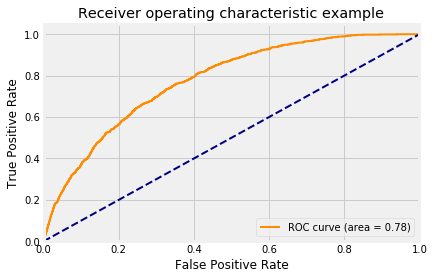

In [24]:
plotROC(y, y_pred)

In [25]:
# pridict[线上，0.774493]
result = pd.DataFrame()
result['id'] = ids
result['target'] = clf.predict_proba(testX)[:,1]
result.to_csv('../submissions/xgb.csv', index=None)

## Easy Ensemble Classifier[0.76]

### 简单尝试

In [26]:
eec = EasyEnsembleClassifier(random_state=0,
                            n_estimators=300,
                            n_jobs=-1,
                            verbose=1)
eec.fit(X_train, y_train)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min finished


EasyEnsembleClassifier(base_estimator=None, n_estimators=300, n_jobs=-1,
                       random_state=0, replacement=False,
                       sampling_strategy='auto', verbose=1, warm_start=False)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  7.7min remaining:  7.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  7.8min finished


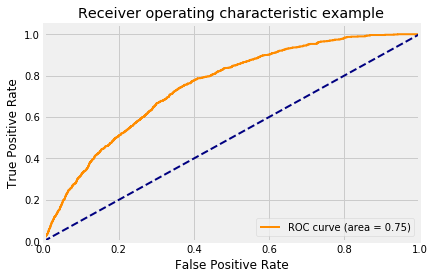

In [27]:
# train
y_train_pred = eec.predict_proba(X_train)[:, 1]
plotROC(y_train, y_train_pred)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.9min finished


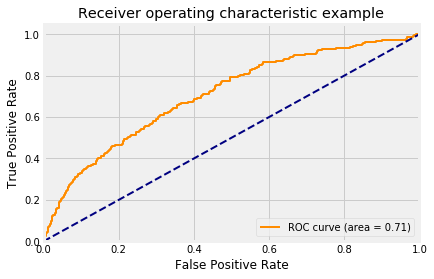

In [28]:
# y_pred_class = eec.predict(X_test)
# confusion_matrix(y_test, y_pred_class)
y_pred = eec.predict_proba(X_test)[:, 1]
plotROC(y_test, y_pred)

### 调参

In [29]:
def objectiveEasy(params):
    time1 = time.time()
    params = {
        'base_estimator': params['base_estimator'](),
        'sampling_strategy': params['sampling_strategy'],
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count = 1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    score_mean = 0
    for tr_idx, val_idx in skf.split(X_train, y_train.values.ravel()):
        clf = EasyEnsembleClassifier(**params,
                                    random_state=0,
                                    n_estimators=300,
                                    n_jobs=-1,
                                    verbose=0)

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr.values.ravel())
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


In [30]:
spaceEasy = {
    'base_estimator': hp.choice('base_estimator', [AdaBoostClassifier, 
                                                  DecisionTreeClassifier,
                                                  BernoulliNB]),
    'sampling_strategy': hp.choice('sampling_strategy', [0.7, 0.8, 0.9,'majority',
                                                        'not minority','not majority',
                                                        'all'])
}

In [31]:
# Set algoritm parameters
bestEasy = fmin(fn=objectiveEasy,
            space=spaceEasy,
            algo=tpe.suggest,
            max_evals=20)

# Print best parameters
bestEasy_params = space_eval(spacespaceEasy, bestEasy)

                                                    
############## New Run ################
params = {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'sampling_strategy': 0.7}
1 CV - score: 0.6681                                
2 CV - score: 0.7042                                
3 CV - score: 0.658                                 
4 CV - score: 0.6659                                
5 CV - score: 0.6622                                
Total Time Run: 6.33                                
Mean ROC_AUC: 0.6716679846839447                    
                                                                            

params = {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'sampling_strategy': 0.8}
1 CV - score: 0.6705                                                                 
2 CV - score: 0.7079                                                                 
3 CV - score: 0.6633                                                                 
4 CV - score: 0.6732                                                                 
 85%|████████▌ | 17/20 [7:20:02<1:24:28, 1689.64s/it, best loss: -0.6916605628090979]


KeyboardInterrupt: 

In [ ]:
clf = EasyEnsembleClassifier(**bestEasy_params,
                            random_state=0,
                            n_estimators=300,
                            n_jobs=-1,
                            verbose=1)

In [ ]:
# training roc
y_train_pred = clf.predict_proba(X_train)[:,1]
plotROC(y_train, y_train_pred)
# test roc
y_pred = clf.predict_proba(X_test)[:,1]
plotROC(y_test, y_pred)

In [ ]:
# fit all data
clf.fit(X, y.values.ravel(), verbose=1)

In [ ]:
y_pred = clf.predict_proba(X)[:, 1]
plotROC(y, y_pred)
roc_auc_score(y, y_pred)

In [ ]:
# pridict
result = pd.DataFrame()
result['id'] = ids
result['target'] = eec.predict_proba(testX)[:, 1]
result.to_csv('../submissions/EasyEnsemble.csv', index=None)

## Balanced Bagging Classifier

### 简单尝试

In [ ]:
bc = BalancedBaggingClassifier(base_estimator=AdaBoostClassifier(),
                              random_state=42,
                              n_estimators=300,
                              n_jobs=-1,
                              verbose=1)
bc.fit(X_train, y_train)

In [ ]:
# training data
plotROC(y_train, bc.predict_proba(X_train)[:,1])

In [ ]:
confusion_matrix(y_train, bc.predict(X_train))

In [ ]:
# test data
y_pred_class = bc.predict(X_test)
# balanced_accuracy_score(y_test, y_pred_class)
confusion_matrix(y_test, y_pred_class)

In [ ]:
y_pred = bc.predict_proba(X_test)[:, 1]
plotROC(y_test, y_pred)

### 调参

In [ ]:
def objectiveBalance(params):
    time1 = time.time()
    params = {
        'base_estimator': params['base_estimator'](),
        'sampling_strategy': params['sampling_strategy'],
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 5
    count = 1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    score_mean = 0
    for tr_idx, val_idx in skf.split(X_train, y_train.values.ravel()):
        clf = BalancedBaggingClassifier(**params,
                                    random_state=0,
                                    n_estimators=300,
                                    n_jobs=-1,
                                    verbose=0)

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr.values.ravel())
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)

In [ ]:
spaceBalance = spaceEasy

In [ ]:
# Set algoritm parameters
bestBalance = fmin(fn=objectiveBalance,
            space=spaceBalance,
            algo=tpe.suggest,
            max_evals=20)

# Print best parameters
bestBalance_params = space_eval(spaceBalance, bestBalance)

In [ ]:
clf = BalancedBaggingClassifier(**bestBalance_params,
                                random_state=0,
                                n_estimators=300,
                                n_jobs=-1,
                                verbose=0)

In [ ]:
# training roc
y_train_pred = clf.predict_proba(X_train)[:,1]
plotROC(y_train, y_train_pred)
# test roc
y_pred = clf.predict_proba(X_test)[:,1]
plotROC(y_test, y_pred)

In [ ]:
# train with all data
clf.fit(X, y.values.ravel(), verbose=1)

In [ ]:
y_pred = clf.predict_proba(X)[:, 1]
plotROC(y, y_pred)
roc_auc_score(y, y_pred)

In [ ]:
result = pd.DataFrame()
result['id'] = ids
result['target'] = bc.predict_proba(testX)[:, 1]
result.to_csv('../submissions/BalancedBaggingClassifier.csv', index=None)